# Handwriting Recognition Using MLP
TensorFlow is used and it has a dataset of 70000 handwriting samples of the numbers 0-9. Our work is to train the model to predict the number in the each image.

Each image is a 28x28 grayscale pixels, so we can treat them as 1D array or a tensor of 784 numbers. We need to flatten out the immage into an array. Then again restructure it to 2D structure.

Now we are going to import the data and reshap it into 1D arrays of 784 poxels and label the data into one-hot-encoded format.

In [3]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [0]:
import numpy as np

mnist = tf.keras.datasets.mnist #importing from keras.dataset

num_classes = 10 #total number of classification i.e 0-9
num_features = 784 #image shape ie 28x28

(x_train, y_train),(x_test, y_test) = mnist.load_data() #loading the data into train and test. x is features and y is labels.

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32) #converting the features into float 32

#Flatten the images to 1D vector of 784 features
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train/255., x_test/255. #Normalise the values from 0-255 to 0-1

Amongst the 70000 samples in the mnist, 60000 samples are split to training sample and 10000 test samples.

so the training images are a tensor of [60000,784] ie 60000 records with 784 features that represent a image. and training labels are 1D tensor of range 0-9.

Lets visualise the data. 

1


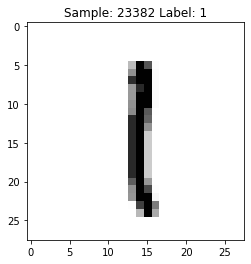

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(num):
  #Print the label of a particular sample
  label = y_train[num]
  print(label)
  
  #Reshape the 784 values to a 28x28 image
  image = x_train[num].reshape([28,28])
  plt.title('Sample: %d Label: %d' %(num,label))
  plt.imshow(image, cmap=plt.get_cmap('gray_r')) #plotting the image and choosing the color in grayscale
  plt.show()


display_sample(23382)

Now we will reshape it back to 784 features and see how this data is passed to the NN.

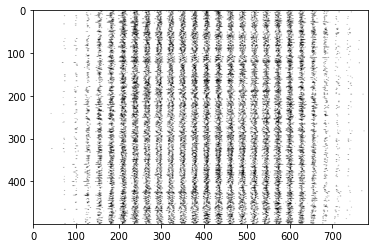

In [7]:
images = x_train[0].reshape([1,784]) #Choosing first sample
for i in range(1,500):
  #choosing first 500 samples and concatinate with each o ther
  images = np.concatenate((images,x_train[i].reshape([1,784])))

plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

Here each row represent a number and the feature data.

Setting up the NN, by setting the parameters for learining rate, training steps or epochs, batch size and display step and hidden neurons.

In [0]:
#Training Parameters: 
learing_rate = 0.001
training_steps = 3000
batch_size = 250 
display_step = 100

#Network Parameters:
n_hidden = 512 #number of neurons.

We are furthur going to divide the training data we have and randomly shuffle them and split them into batches.

In [0]:
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train)) #used to make a dataset from the x_train and y_train
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1) #Shuffle the data and split them into batches of 250 records and fetch the first batch

Setting up the NN. Create variables to store the weights and biases of layers. 

Initialise with random values initially and update them as we go.

In [0]:
#Storing weights and biases.

random_normal = tf.initializers.random_normal() # random value generator to generate weigths randomly

weights = {
    'h' : tf.Variable(random_normal([num_features, n_hidden])), #h for hidden layers. This will create 512 variables which has weights for hidden neuron.
    'out' : tf.Variable(random_normal([n_hidden, num_classes])) #output will be of 10 neurons with likelihood of what the input is between 0-9
}
biases = {
    #Initialised to zero
    'b' : tf.Variable(tf.zeros([n_hidden])), #one for each neuron
    'out' : tf.Variable(tf.zeros([num_classes]))# one for each output
}

Setting up Neural Network function.

In [0]:
#Defining NN
def neural_net(inputData):
  #Connecting the hidden layer with the neurons
  hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b']) #Setting up the neurons in HL by multiplying weights with the input data and adding the result with the biases ie w.x + b
  #Applying Activation function to the result of the summation.
  hidden_layer = tf.nn.sigmoid(hidden_layer) #Applying sigmoid activation function because for the non-linearity

  #Connecting output layer with output neurons
  out_layer = tf.add(tf.matmul(hidden_layer, weights['out']), biases['out']) #Setting up the neurons in OL by using w.x+b
  #To normalize the output to a probability distribution, we use softmax
  return tf.nn.softmax(out_layer)

 Train the neural Net. 
 Defining loss function(cross entropy): Used to measure the progress in gradient descent, ehich applies a logarthamic scale to the incorrect classifications. In this function y_pred is the output of our final layer. and we are comparing it with the labels that we have as y_true.

 To compare the known labels of 0-9 to the output of the NN, we need to convert the labels to "one-hot" encoding. our output layer has each neuron for each possible outcome. Similarly our true value also should be of that format eg. y_true is 1 then we would represent it as [0,1,0,0,0,0,0,0,0]. Thus making it easier to compare.

In [0]:
def cross_entropy(y_pred,y_true):
  #Encode the labels to one hot vector.
  y_true = tf.one_hot(y_true, depth=num_classes) #depth is the size of the encoder. here its 10 ie 0-9
  y_pred = tf.clip_by_value(y_pred, 1e-9,1.)#To clip the output so that 0 values are omitted(to prevent log(0) error)

  #Compute cross entropy
  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Defining Optimizer: Stocastic Gradient Descent.


In [0]:
optimizer = tf.keras.optimizers.SGD(learing_rate) #Stocastic GD is defined

def run_optimization(x, y):
  # Tying everything together using GradientTape function for auto differentiation. neural net is optimized within the function.
  with tf.GradientTape() as g:
    pred = neural_net(x)
    loss = cross_entropy(pred, y) 

  trainable_variables = list(weights.values()) + list(biases.values()) # these are the values to update

  #Computing the gradient
  gradients = g.gradient(loss, trainable_variables)

  #Updating the weights and biases using the gradient ie if its negative then its added else if its positve its subtracted to the weights
  optimizer.apply_gradients(zip(gradients, trainable_variables))

Defining Accuracy funtion: will look at whether the output array matches with the lable and returns 1 if it does and 0 if it doesnt.
accuracy then takes average og all the classification to produce overall score of the model

In [0]:
def accuracy(y_pred, y_true):
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true,tf.int64))  #Checking if the highest score in prediction vector ie(1) to get the number, and the label are same.
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1) #returns the mean of all correct preditions

Now lets train the model. 

for every training step we will take a batch from the training data, we will run optimizer and compute the weights and biases and print out t9he loss and accuracy every 100 epochs

In [17]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1): 
  #we are taking the batchs based on the training steps/epoch that we had defined in the parameters
  #Running the optimizer function to train and update the w and b values
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
9    pred = neural_net(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print("Training epoch: %i, loss: %f, accuracy: %f" %(step, loss, acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training epoch: 100, loss: 410.567627, accuracy: 0.736000
Training epoch: 200, loss: 319.888092, accuracy: 0.804000
Training epoch: 300, loss: 279.717712, accuracy: 0.844000
Training epoch: 400, loss: 263.835449, accuracy: 0.864000
Training epoch: 500, loss: 213.915298, accuracy: 0.852000
Training epoch: 600, loss: 152.989182, accuracy: 0.904000
Training epoch: 700, loss: 165.522064, accuracy: 0.892000
Training epoch: 800, loss: 144.511063, accuracy: 0.900000
Training epoch: 900, loss: 68.808044, accuracy: 0.932000
Training epoch: 1000, loss: 137.699982, accuracy: 0.900000
Training epoch: 1100, loss: 130.175735, accuracy: 0.912000
Training epoch: 1200, loss: 85.270752, accuracy: 0.924000
Training epoch: 1300, loss: 131.579254, accuracy: 0.908000
Training epoch: 1400, loss: 188.744400, accuracy: 0.872000
Training epoch: 1500, loss: 70.557251, accuracy: 0.940000
Training epoch: 1600, loss: 140.7

In [18]:
# Checking with the test data
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.916100
